# Background 
This code implements a spiking neural net with conductance in input. the following equations govern the dynamic of the network. 
### transmembrane voltage dynamics
first we model the transmembrane voltage as 
$$\tau_m \frac{dV_i}{dt}= - V_i(t)+ R_m \times I^{syn}_i(t) $$ 
$$ {\tau_a}_i \frac{dB_i(t)}{dt} = b_i^0 -B_i(t)$$ 
where, $R_m$ is membrane resistance, $\tau_m$ is membrane time constant, and ${\tau_a}_i$ is adaptation time constant  .
the synaptic current relates to synaptic activations in the following way
$$I^{syn}_i(t)= \sum_j W^{in}_{ij} \times X(t) + \sum_j W^{rec}_{ij} \times S_j(t) $$ 

### neuron firing dynamics 
The firing dynamics of the neuron is model as a simple reseting. More specifically, 
$$V_i \rightarrow V_{reset} \ \ \  if \ \ \ V_i>=B_{i} $$

$ V_{\Theta}$ represent the threshold voltage and $V_{reset}$ is the reset voltage of the neuron.

### Input dynamics 
Input synapes are the the site of learning in the spiking network. Below a conductance based formulation is presented. 
First, the time-dependent input conductance to membrane is calculated as follows 
$$ g_i(t) = \sum_j W_{ij} S_{j}(t) $$

in the current version $S_{j}(t)$ is equal to spike at timestep $t$ without any decay dynamics. 
-  TODO the term $j$ reperesent all the neurons that have a synapse onto the neuron $i$. the time dependence of conductance is due to $S(t)$ which represent the spiking activity for neurons connected to neuron $i$ . The spiking activity has the following governing equations 
$$ S_{j} \rightarrow S_{j}+1 \quad if \ neuron\ j\ fires$$
$$ \frac{dS_{j}(t)}{dt} = \frac{-S_{j}(t)}{\tau_s}$$ 

### Spike Adaptation dynamics 
The threshold for spiking increases with every spike emited from a neuron with the following dynamics 
$$ B_{i}(t) \rightarrow B_{i}(t)+\frac{\beta}{{\tau_a}_i} \quad if \ neuron\ i\ fires$$

### References 
-  Fiete, Ila R., Walter Senn, Claude Z. H. Wang, and Richard H. R. Hahnloser. 2010. “Spike-Time-Dependent Plasticity and Heterosynaptic Competition Organize Networks to Produce Long Scale-Free Sequences of Neural Activity.” Neuron 65 (4): 563–76. 

-  Bellec, Guillaume, Darjan Salaj, Anand Subramoney, Robert Legenstein, and Wolfgang Maass. 2018. “Long Short-Term Memory and Learning-to-Learn in Networks of Spiking Neurons.” arXiv [cs.NE]. arXiv. http://arxiv.org/abs/1803.09574.



### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm

import numpy as np
import tensorflow as tf

import collections
import hashlib
import numbers
from datetime import datetime
from pathlib import Path
import os

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim
from matplotlib.colors import LinearSegmentedColormap

import kernl_spiking_cell_v4 as kernl_spiking_cell


first testing the code on a constant input 

rnn/kernl_spike__cell/temporal_filter:0 [0.0160952  0.01703993 0.00509979 0.00849975 0.01340762 0.01404035
 0.00773261 0.0072224  0.0168091  0.00331535]
rnn/kernl_spike__cell/sensitivity_tensor:0 [[-0.2895179  -0.21549076  0.37766862  0.4535898   0.46838212 -0.4576802
   0.2166292   0.45034617  0.36364746 -0.33681166]
 [ 0.4352615   0.11548156  0.23960799  0.3196448   0.2995206  -0.48527798
  -0.17159083  0.3320182   0.18415058 -0.42405698]
 [ 0.50959635 -0.19311044 -0.1698744   0.11489755  0.31935054 -0.47520253
  -0.04943055 -0.47779036  0.24530512  0.37577313]
 [ 0.07575625  0.00455189 -0.26723647  0.4626125   0.0248667  -0.45372602
  -0.2062782  -0.27278876  0.3768664  -0.43764707]
 [ 0.11460322 -0.14290646 -0.04486102 -0.35799825  0.5129243   0.52087677
   0.02646977  0.3070042  -0.40320912 -0.36178422]
 [ 0.12917066 -0.4555046   0.52119064  0.03461552 -0.18100423  0.1930837
   0.42183596 -0.45953715 -0.40791497  0.41065246]
 [ 0.4716829   0.055471   -0.4184236   0.5222399  -0.123

Text(0.5, 1.0, 'integral of (h-h_hat)')

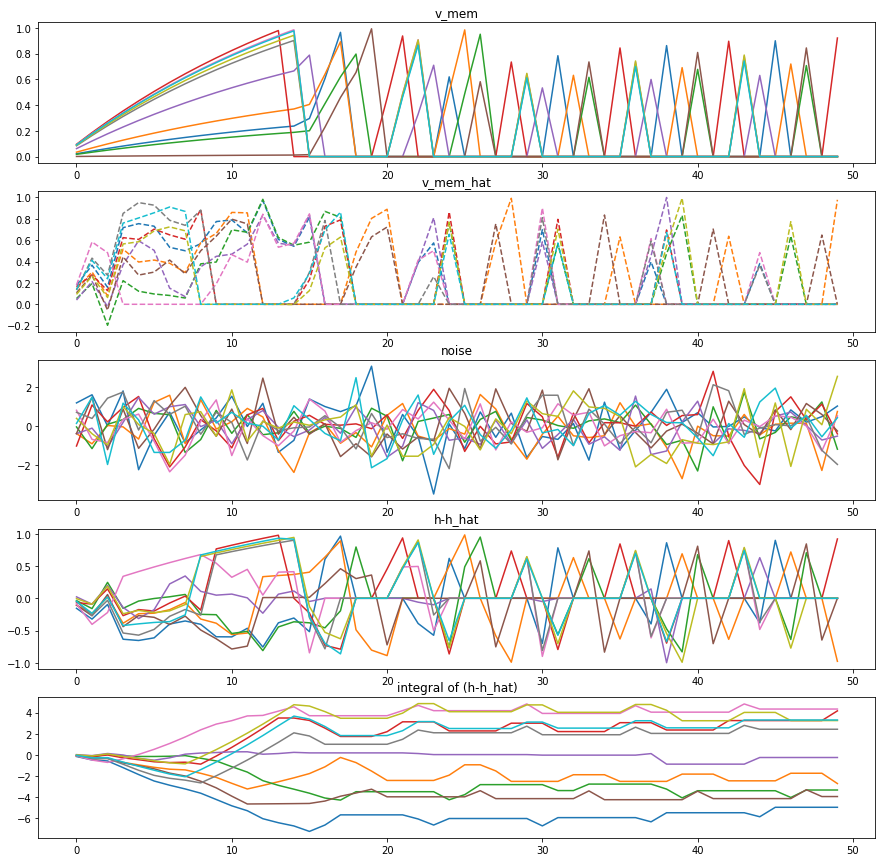

In [12]:
batch_size = 1
sequence_length = 50
num_inputs=1
num_units=10
#input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
input_spikes=1.0*np.ones([batch_size,sequence_length,num_inputs])
tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
kernl_snn = kernl_spiking_cell.kernl_spike_Cell(num_units=num_units,
                                                num_inputs=num_inputs,
                                                state_is_tuple=True,
                                                output_is_tuple=True,
                                                tau_s=10.0,
                                                tau_refract=5.0,
                                                tau_m=20.0,
                                                noise_param=1.0,
                                                time_steps=sequence_length,
                                                kernel_initializer=tf.initializers.random_uniform(),
                                                bias_initializer=tf.initializers.zeros())
outputs, state = tf.nn.dynamic_rnn(cell=kernl_snn, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,15])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.squeeze(axis=0))
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.v_mem_hat.squeeze(axis=0),'--')
ax.set_title('v_mem_hat')
ax=plt.subplot(5,1,3)
ax.plot(output_run.psi.squeeze(axis=0))
ax.set_title('noise')
ax=plt.subplot(5,1,4)
ax.plot(output_run.v_mem.squeeze(axis=0)-output_run.v_mem_hat.squeeze(axis=0))
ax.set_title('h-h_hat')
ax=plt.subplot(5,1,5)
ax.plot(np.cumsum(output_run.v_mem.squeeze(axis=0)-output_run.v_mem_hat.squeeze(axis=0),axis=0))
ax.set_title('integral of (h-h_hat)')


next we create a recurrent version to verify the functionality 

### computation graph for learning $M$ and $K(\tau)$

In the original version of kernl implemented in rnn, the value of h was a continues function in time, and the perturbation could accumulate throughout a trial, which made the calculation of difference between perturbed and non-perturbed h straightforward. However in the spiking network here, there is a complication with the value of v_mem being discontinuous. how can we aleviate this problem. based on the example about, we can see that if we integrate the difference between them, we get a smoother function to calculate gradients from. we first try to optimize based on final difference between the integrals.  

In [15]:
tensor_learning_rate=1e-3 
training_steps = 5000
batch_size = 25
display_step = 250
grad_clip=200


batch_size = 1
sequence_length = 250
num_inputs=1
num_units=10

#input_spikes=1.0*np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # define the network
    X = tf.placeholder("float", [None, sequence_length, num_inputs])
   
    tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
    kernl_snn = kernl_spiking_cell.kernl_spike_Cell(num_units=num_units,
                                                num_inputs=num_inputs,
                                                state_is_tuple=True,
                                                output_is_tuple=True,
                                                tau_s=10.0,
                                                tau_refract=5.0,
                                                tau_m=20.0,
                                                noise_param=0.3,
                                                time_steps=sequence_length,
                                                kernel_initializer=tf.initializers.random_uniform(),
                                                bias_initializer=tf.initializers.zeros())
    kernl_outputs, kernl_state = tf.nn.dynamic_rnn(cell=kernl_snn, dtype=tf.float32, inputs=X)
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    # 
    find_joing_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for kernl 
    with tf.name_scope('kernl_Trainables') as scope:
        kernl_temporal_filter_index= find_joing_index(trainables,'kernl','temporal_filter')
        kernl_sensitivity_tensor_index= find_joing_index(trainables,'kernl','sensitivity_tensor')
    # 
        kernl_tensor_training_indices=np.asarray([kernl_sensitivity_tensor_index,kernl_temporal_filter_index],dtype=np.int)
        kernl_tensor_trainables= [trainables[k] for k in kernl_tensor_training_indices]
     
    with tf.name_scope('kernl_train_tensors') as scope: 
        state_diff_int=tf.subtract(kernl_outputs.v_mem_hat[:,:,:], kernl_outputs.v_mem[:,:,:])
        estimate_state_diff_int=tf.einsum('unv,vk->unk',kernl_outputs.Theta,trainables[kernl_sensitivity_tensor_index])
        kernl_loss_state_prediction=tf.losses.mean_squared_error(state_diff_int,estimate_state_diff_int)
        kernl_tensor_optimizer = tf.train.RMSPropOptimizer(learning_rate=tensor_learning_rate)
        kernl_tensor_grads=tf.gradients(ys=kernl_loss_state_prediction,xs=kernl_tensor_trainables)
        kernl_tensor_grad_and_vars=list(zip(kernl_tensor_grads,kernl_tensor_trainables))
        kernl_tensor_train_op=kernl_tensor_optimizer.apply_gradients(kernl_tensor_grad_and_vars)
    init = tf.global_variables_initializer()    
    
    ##################
    # SUMMARIES ######
    ##################
    
    with tf.name_scope("kernl_tensor_summaries") as scope: 
        # kernl sensitivity tensor 
        tf.summary.histogram('kernl_sensitivity_tensor_grad',kernl_tensor_grads[0]+1e-10)
        tf.summary.histogram('kernl_sensitivity_tensor',trainables[kernl_sensitivity_tensor_index]+1e-10)
        # kernl temporal filter 
        tf.summary.histogram('kernl_temporal_filter_grad',kernl_tensor_grads[1]+1e-10)
        tf.summary.histogram('kernl_temporal_filter',trainables[kernl_temporal_filter_index]+1e-10)
        # kernl loss 
        tf.summary.scalar('kernl_loss_state_prediction',kernl_loss_state_prediction+1e-10)
        # kernl senstivity tensor and temporal filter 
        tf.summary.image('kernl_sensitivity_tensor',tf.expand_dims(tf.expand_dims(trainables[kernl_sensitivity_tensor_index],axis=0),axis=-1))
        tf.summary.image('kernl_sensitivity_tensor_grad',tf.expand_dims(tf.expand_dims(kernl_tensor_grads[0],axis=0),axis=-1))
        tf.summary.image('kernl_temporal_filter',tf.expand_dims(tf.expand_dims(tf.expand_dims(trainables[kernl_temporal_filter_index],axis=0),axis=-1),axis=-1))
        tf.summary.image('kernl_temporal_filter_grad',tf.expand_dims(tf.expand_dims(tf.expand_dims(kernl_tensor_grads[1],axis=0),axis=-1),axis=-1))
        kernl_tensor_merged_summary_op=tf.summary.merge_all(scope="kernl_tensor_summaries")
    
     
    saver = tf.train.Saver()

In [16]:
log_dir = "/home/eghbal/MyData/KeRNL/logs/kernl_snn_cell/MNIST_gc_%d_eta_m_%d_batch_%d_run_%s" %(grad_clip,tensor_learning_rate,batch_size, datetime.now().strftime("%Y%m%d_%H%M"))
Path(log_dir).mkdir(exist_ok=True, parents=True)
filelist = [ f for f in os.listdir(log_dir) if f.endswith(".local") ]
for f in filelist:
    os.remove(os.path.join(log_dir, f))

Step: 2, keRNL tensor Loss 8.094,
Step: 251, keRNL tensor Loss 0.151,
Step: 501, keRNL tensor Loss 0.074,
Step: 751, keRNL tensor Loss 0.119,
Step: 1001, keRNL tensor Loss 0.039,
Step: 1251, keRNL tensor Loss 0.029,
Step: 1501, keRNL tensor Loss 0.069,
Step: 1751, keRNL tensor Loss 0.024,
Step: 2001, keRNL tensor Loss 0.024,
Step: 2251, keRNL tensor Loss 0.116,
Step: 2501, keRNL tensor Loss 0.065,
Step: 2751, keRNL tensor Loss 0.054,
Step: 3001, keRNL tensor Loss 0.076,
Step: 3251, keRNL tensor Loss 0.052,
Step: 3501, keRNL tensor Loss 0.102,
Step: 3751, keRNL tensor Loss 0.075,
Step: 4001, keRNL tensor Loss 0.018,
Step: 4251, keRNL tensor Loss 0.094,
Step: 4501, keRNL tensor Loss 0.027,
Step: 4751, keRNL tensor Loss 0.055,
Step: 5001, keRNL tensor Loss 0.044,


Text(0.5, 1.0, 'integral of (h-h_hat)')

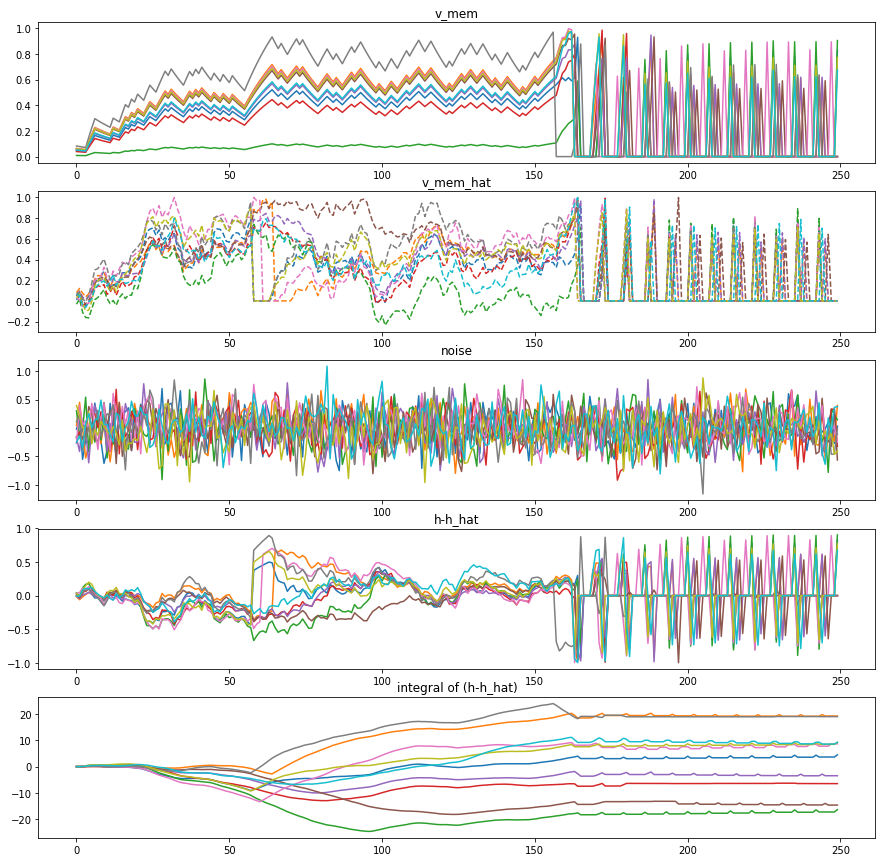

In [17]:
tb_writer = tf.summary.FileWriter(log_dir,graph)
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for step in range(1,training_steps+1):
        input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
        kernl_tensor_train,kernl_loss_state=sess.run([kernl_tensor_train_op,kernl_loss_state_prediction], feed_dict={X: input_spikes})        
        # run summaries 
        kernl_tensor_merged_summary=sess.run(kernl_tensor_merged_summary_op, feed_dict={X: input_spikes})
        tb_writer.add_summary(kernl_tensor_merged_summary, global_step=step)
        
       
        if step % display_step==0 or step==1 : 
            # get batch loss and accuracy 
            print('Step: {}, keRNL tensor Loss {:.3f},'.format(step + 1, kernl_loss_state))
            output_run , state_run = sess.run([kernl_outputs, kernl_state], feed_dict={X: input_spikes})
plt.figure(figsize=[15,15])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.squeeze(axis=0))
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.v_mem_hat.squeeze(axis=0),'--')
ax.set_title('v_mem_hat')
ax=plt.subplot(5,1,3)
ax.plot(output_run.psi.squeeze(axis=0))
ax.set_title('noise')
ax=plt.subplot(5,1,4)
ax.plot(output_run.v_mem.squeeze(axis=0)-output_run.v_mem_hat.squeeze(axis=0))
ax.set_title('h-h_hat')
ax=plt.subplot(5,1,5)
ax.plot(np.cumsum(output_run.v_mem.squeeze(axis=0)-output_run.v_mem_hat.squeeze(axis=0),axis=0))
ax.set_title('integral of (h-h_hat)')
            

In [14]:
input_spikes

array([[[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]]])